Data Loading

In [20]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Pad(3, fill=1),  # Adds padding of size 6 around each image
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.where(x > 0.5, torch.ones_like(x), torch.zeros_like(x))),

])

train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Checking data
images, labels = next(iter(train_loader))
print(f"Batch of images shape: {images.shape}")
print(f"Batch of labels shape: {labels.shape}")

Batch of images shape: torch.Size([32, 1, 34, 34])
Batch of labels shape: torch.Size([32])


Visualization

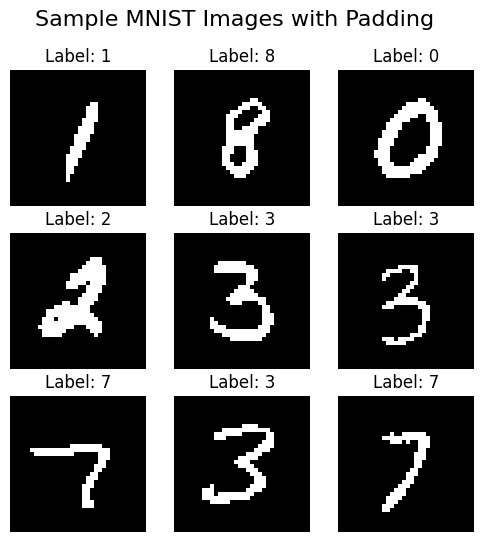

In [21]:
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(img):
    img = img * 0.5 + 0.5  # Undo normalization to bring back pixel values to [0, 1] range
    return img

images, labels = next(iter(train_loader))

fig, axes = plt.subplots(3, 3, figsize=(6, 6))  # 3x3 grid of images
fig.suptitle("Sample MNIST Images with Padding", fontsize=16)

for i, ax in enumerate(axes.flat):
    img = images[i].squeeze()
    img = unnormalize(img)
    ax.imshow(img, cmap='gray')
    ax.set_title(f"Label: {labels[i].item()}")
    ax.axis('off')

plt.show()


MaskedConv2d

In [22]:
import torch
import torch.nn as nn



class MaskedConv2d(nn.Conv2d):
    """
    Class extending nn.Conv2d to use masks.
    """
    def __init__(self, mask_type, in_channels, out_channels, kernel_size, padding= 'same'):
        padding = (kernel_size // 2) if padding=='same' else padding
        super(MaskedConv2d, self).__init__(in_channels, out_channels, kernel_size, padding=padding)
        self.register_buffer('mask', torch.ones(out_channels, in_channels, kernel_size, kernel_size).float())

        if mask_type == 'A':

            center = kernel_size//2
            self.mask[:,:,center+1:,:]= 0
            self.mask[:,:,center,center:]= 0
        else:
            center = kernel_size//2
            self.mask[:,:,center+1:,:]= 0
            self.mask[:,:,center,center+1:]= 0
    
    def forward(self, x):
        # Apply the mask to the weights
        self.weight.data *= self.mask
        # Call the parent class forward method
        return super(MaskedConv2d, self).forward(x)

# mask A vs mask B

In Mask A, to satisfy the autoregressive assumption, we should prevent the model from viewing the current pixel value. However, in the subsequent layer, the model will generate an initial estimate for all pixels. In this case, we may allow the model to utilize these predictions for learning and optimization since they are model-generated estimates rather than actual pixel values.



Model architecture

In [23]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class PixelCNN(nn.Module):
    def __init__(self):
        super(PixelCNN, self).__init__()

        # Masked Convolutional layers
        self.conv1 = MaskedConv2d(mask_type='A',in_channels=1,out_channels=64,kernel_size=7)
        self.conv2 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=7)
        self.conv3 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=7)
        self.conv4 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=7)
        self.conv5 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=7)
        self.conv6 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=7)
        self.conv7 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=64,kernel_size=1)
        self.conv8 = MaskedConv2d(mask_type='B',in_channels=64,out_channels=1,kernel_size=1)



    def forward(self, x):
        # MaskedConv layers with Relu function
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = self.conv8(x)
        x = torch.sigmoid(x)


        return x


In [30]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def sample_pixelcnn(model, device, image_size=(40, 40), num_samples=1):
    """
    Generate samples from a trained PixelCNN model.
    
    Args:
        model (nn.Module): Trained PixelCNN model.
        device (torch.device): Device to perform computations on.
        image_size (tuple): Size of the image to generate (height, width).
        num_samples (int): Number of images to generate.
        
    Returns:
        samples (torch.Tensor): Generated samples of shape (num_samples, 1, H, W).
    """
    model.eval()
    samples = torch.ones(num_samples, 1, image_size[0], image_size[1], device=device)

    with torch.no_grad():
        for i in tqdm(range(image_size[0]), desc="Generating Rows"):
            for j in range(image_size[1]):
                # Predict the probability of the current pixel
                preds = model(samples)
                
                probs = preds[:, :, i, j]
                # Sample from the Bernoulli distribution
                sampled_pixel = torch.bernoulli(probs).float()
                
                # Set the pixel value (ensure the correct shape)
                samples[:, 0, i, j] = sampled_pixel.squeeze(1)  # Squeeze the channel dimension

    return samples.cpu()

def generate_and_plot_images(model, device, image_size=(40, 40), num_samples=100, grid_size=(10, 10)):
    """
    Generate multiple samples using PixelCNN and plot them in a single figure.
    
    Args:
        model (nn.Module): Trained PixelCNN model.
        device (torch.device): Device to perform computations on.
        image_size (tuple): Size of the image to generate (height, width).
        num_samples (int): Number of images to generate.
        grid_size (tuple): Size of the grid to display the images in (rows, cols).
    """
    # Generate samples
    samples = sample_pixelcnn(model, device, image_size, num_samples)
    
    # Create a grid of subplots to display the images
    fig, axes = plt.subplots(grid_size[0], grid_size[1], figsize=(10, 10))
    
    # Flatten the axes for easy indexing
    axes = axes.flatten()
    
    # Plot each generated image
    for i in range(num_samples):
        ax = axes[i]
        ax.imshow(samples[i, 0], cmap='gray')
        ax.axis('off')  # Hide axes
    
    plt.tight_layout()
    plt.show()


Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


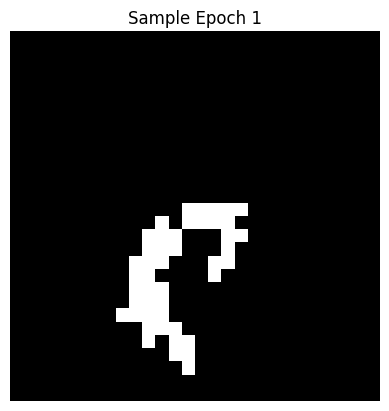

Epoch 1/30
Train Loss: 0.1005
Validation Loss: 0.0724



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


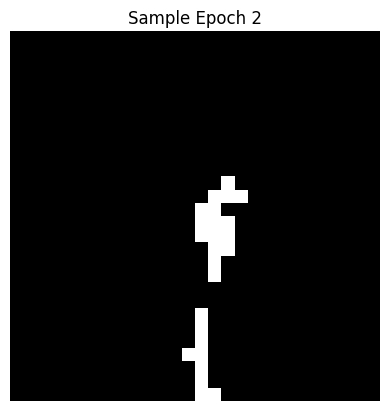

Epoch 2/30
Train Loss: 0.0657
Validation Loss: 0.0607

Epoch 3/30
Train Loss: 0.0578
Validation Loss: 0.0558



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


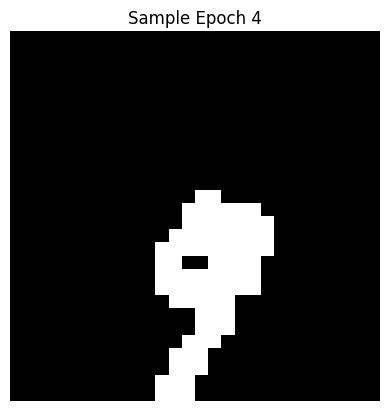

Epoch 4/30
Train Loss: 0.0550
Validation Loss: 0.0542

Epoch 5/30
Train Loss: 0.0541
Validation Loss: 0.0537



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


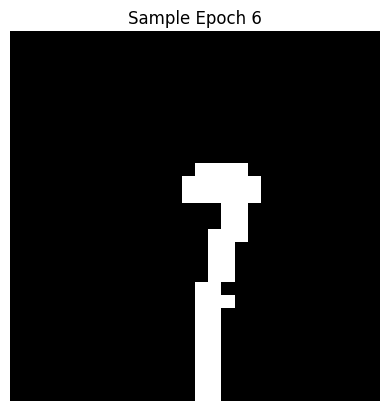

Epoch 6/30
Train Loss: 0.0534
Validation Loss: 0.0534

Epoch 7/30
Train Loss: 0.0528
Validation Loss: 0.0526



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


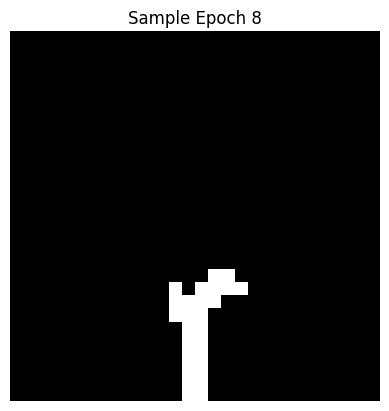

Epoch 8/30
Train Loss: 0.0524
Validation Loss: 0.0520

Epoch 9/30
Train Loss: 0.0521
Validation Loss: 0.0522



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


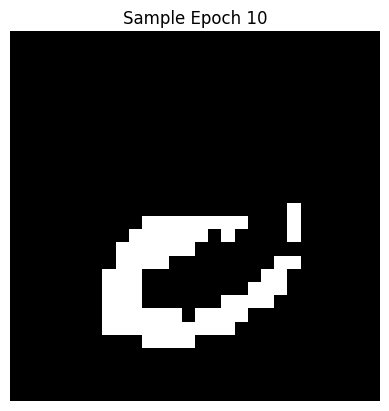

Epoch 10/30
Train Loss: 0.0518
Validation Loss: 0.0518

Epoch 11/30
Train Loss: 0.0504
Validation Loss: 0.0507



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


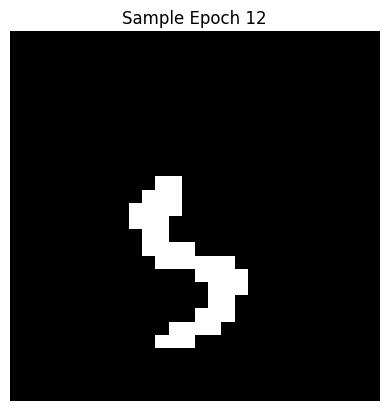

Epoch 12/30
Train Loss: 0.0503
Validation Loss: 0.0508

Epoch 13/30
Train Loss: 0.0502
Validation Loss: 0.0506



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


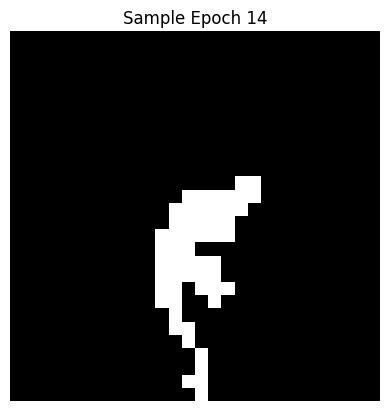

Epoch 14/30
Train Loss: 0.0501
Validation Loss: 0.0506

Epoch 15/30
Train Loss: 0.0501
Validation Loss: 0.0505



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


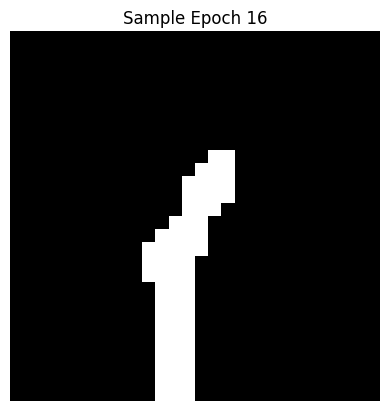

Epoch 16/30
Train Loss: 0.0500
Validation Loss: 0.0505

Epoch 17/30
Train Loss: 0.0500
Validation Loss: 0.0505



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


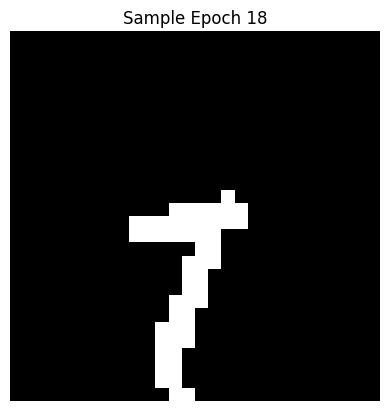

Epoch 18/30
Train Loss: 0.0499
Validation Loss: 0.0505

Epoch 19/30
Train Loss: 0.0499
Validation Loss: 0.0505



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.07it/s]


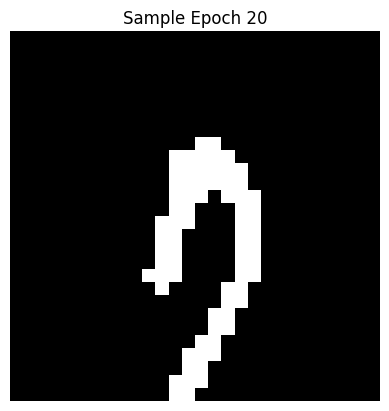

Epoch 20/30
Train Loss: 0.0499
Validation Loss: 0.0504

Epoch 21/30
Train Loss: 0.0497
Validation Loss: 0.0504



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


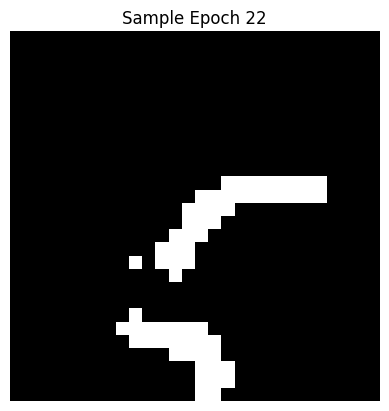

Epoch 22/30
Train Loss: 0.0496
Validation Loss: 0.0503

Epoch 23/30
Train Loss: 0.0496
Validation Loss: 0.0503



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


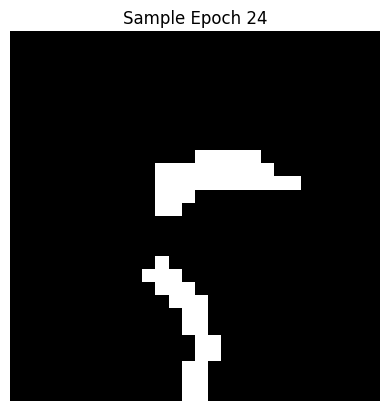

Epoch 24/30
Train Loss: 0.0496
Validation Loss: 0.0503

Epoch 25/30
Train Loss: 0.0496
Validation Loss: 0.0504



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


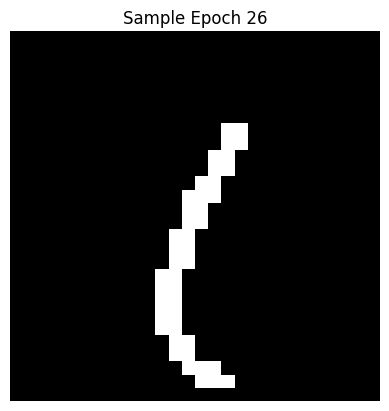

Epoch 26/30
Train Loss: 0.0496
Validation Loss: 0.0503

Epoch 27/30
Train Loss: 0.0496
Validation Loss: 0.0503



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.05it/s]


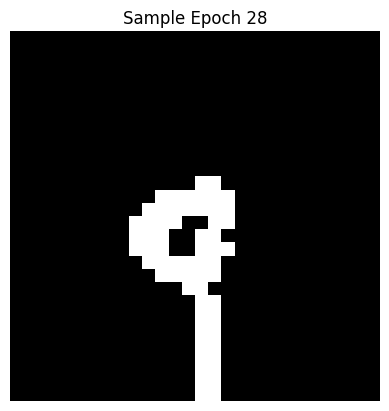

Epoch 28/30
Train Loss: 0.0496
Validation Loss: 0.0503

Epoch 29/30
Train Loss: 0.0496
Validation Loss: 0.0503



Generating Rows: 100%|██████████| 28/28 [00:02<00:00, 13.06it/s]


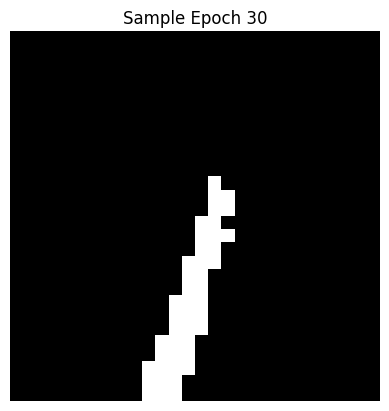

Epoch 30/30
Train Loss: 0.0496
Validation Loss: 0.0503



In [25]:
import torch
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PixelCNN().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 30

train_loss_history = []
val_loss_history = []

def train(model, loader, criterion, optimizer):
    model.train()
    runningLoss = 0
    for input, _ in loader:
        input = input.to(device)
        outputs = model(input)
        loss = criterion(outputs, input)
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        runningLoss += loss.item()
    return runningLoss / len(loader)

def validation(model, loader, criterion):
    model.eval()
    runningLoss = 0
    with torch.no_grad():
        for input, _ in loader:
            input = input.to(device)
            outputs = model(input)
            loss = criterion(outputs, input)
            runningLoss += loss.item()
    return runningLoss / len(loader)

import matplotlib.pyplot as plt
import torch
from torch.optim.lr_scheduler import StepLR


scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
for epoch in range(num_epochs):
    # Training phase
    model.train()
    train_loss = train(model, train_loader, criterion, optimizer)
    
    # Validation phase
    model.eval()
    with torch.no_grad():
        val_loss = validation(model, test_loader, criterion)
    
    # Record losses
    train_loss_history.append(train_loss)
    val_loss_history.append(val_loss)
    
    # Generate and plot samples every 10 epochs
    if (epoch + 1) % 2 == 0 or epoch == 0:
        generated_samples = sample_pixelcnn(model, device, image_size=(28, 28), num_samples=1)
        img = generated_samples[0].squeeze().cpu().numpy()  # Move to CPU and convert to NumPy
        plt.imshow(img, cmap='gray')
        plt.title(f"Sample Epoch {epoch+1}")
        plt.axis('off')
        plt.show()
    
    # Step the scheduler
    scheduler.step()
    
    # Print progress
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}")
    print(f"Validation Loss: {val_loss:.4f}\n")



Loss history

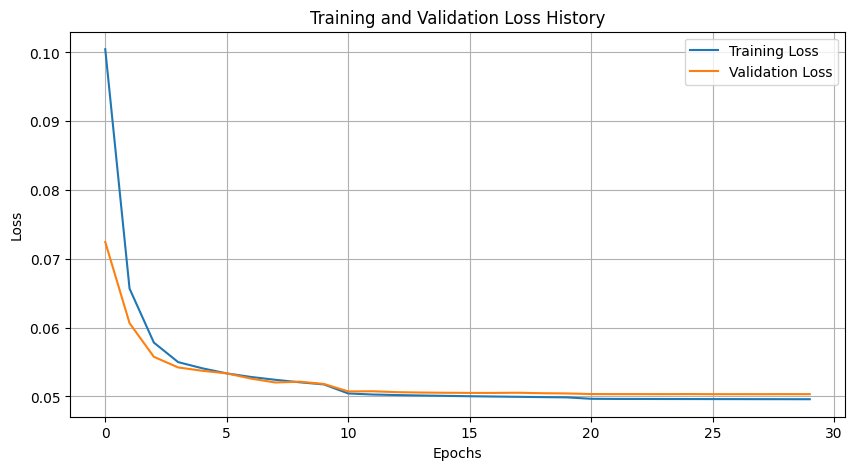

In [26]:
# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.title('Training and Validation Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

Generating Rows: 100%|██████████| 34/34 [00:31<00:00,  1.07it/s]


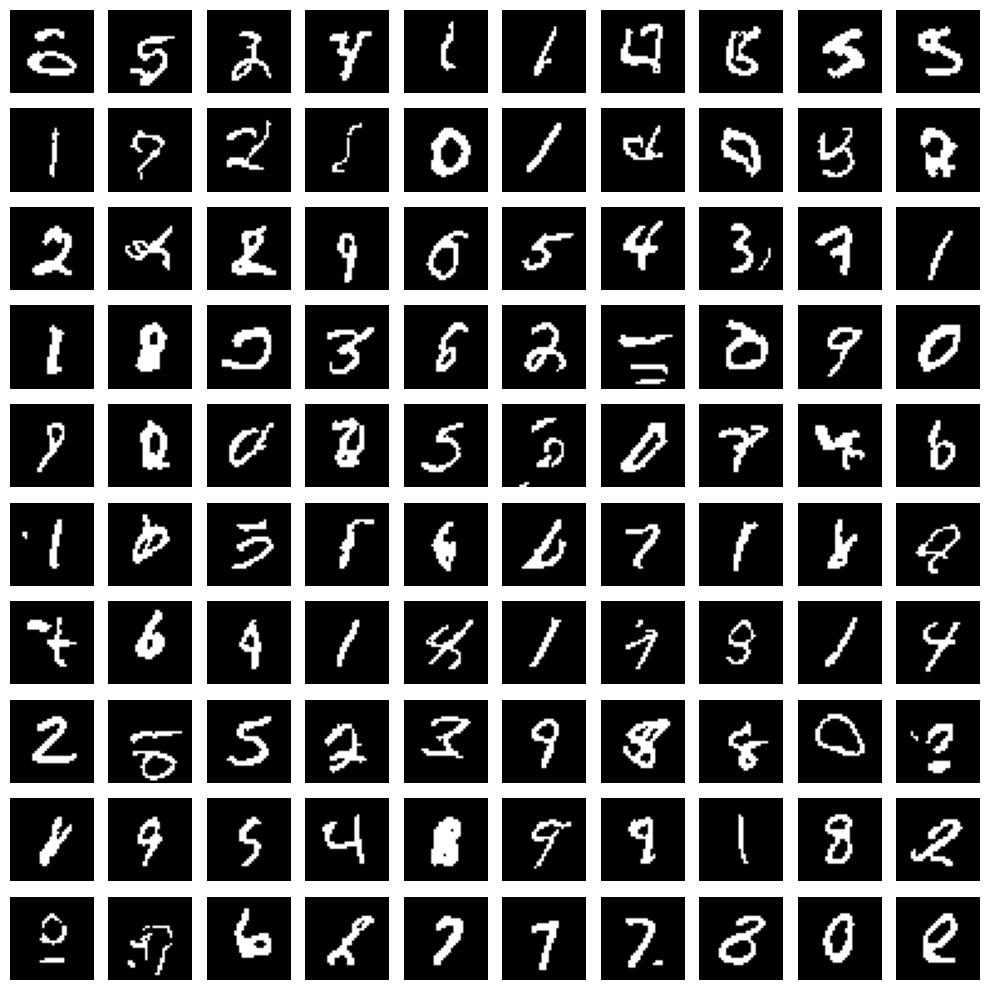

In [31]:
generate_and_plot_images(model, device, image_size=(34, 34), num_samples=100, grid_size=(10, 10))
